# BGC Sample Project


In this notebook, the code has the simplest regional ocean model setup possible through CrocoDash. In the comments and descriptions, we'll provide some of the ways you can add and build on this demo (recreate a specific domain - like GFDL's NWA12, run with CICE - the sea-ice model in CESM, run with MARBL - the ocean BGC model in CESM, and beyond!) 

This notebook is designed for new users of CrocoDash and CESM who want to set up a simple regional ocean model. By following the steps, you will learn how to generate a domain, configure a CESM case, prepare ocean forcing data, and run your simulation.


A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

Every specialization of CrocoDash will use this framework.


# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid(
  resolution = 0.05, # in degrees
  xstart = 278.0, # min longitude in [0, 360]
  lenx = 3.0, # longitude extent in degrees
  ystart = 7.0, # min latitude in [-90, 90]
  leny = 3.0, # latitude extent in degrees
  name = "panama1",
)

# Try changing the grid resolution or domain boundaries to model a different region!

The above cell is a way to generate a rectangular lat/lon grid through CrocoDash

If you're interested in using an already generated regional grid, you can do that by passing in a supergrid, like in [this demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html).

If you're interested in subsetting an already generated global grid, you can do that by passing in lat/lon args, like in [this demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/subset_global.html).

## Step 1.2: Topography

The below three cells are a way to generate topography with a given grid using the [GEBCO](https://www.gebco.net/) dataset. 

If you're interested in using a previously generated topography for your grid, you can do that by passing in a topography file, like in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html)

In [2]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5, # in meters
)

In [3]:
bathymetry_path='/glade/campaign/cgd/oce/projects/CROCODILE/workshops/2025/CrocoDash/data/gebco/GEBCO_2024.nc'

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation"
)

If bathymetry setup fails, rerun this function with write_to_file = True
Begin regridding bathymetry...

Original bathymetry size: 7.39 Mb
Regridded size: 0.09 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,make sure function argument write_to_file = True and,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regrid

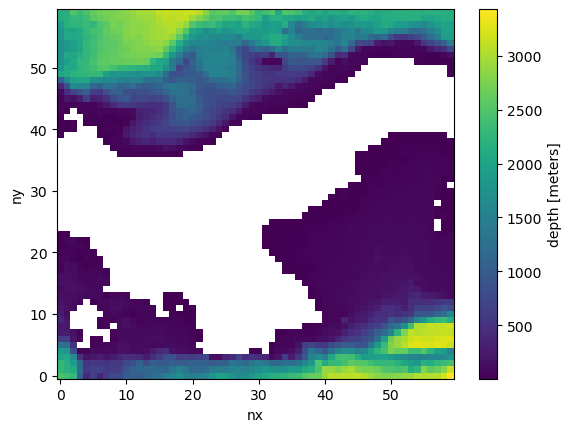

In [4]:
# Validate that the topography looks right!
topo.depth.plot()

### Editing the topography

Regridding topography from GEBCO may result in features we do not necessarily want. The Topo Editor is a tool to edit the bathymetry as wanted. You can do things like erasing basins, opening or closing bays, or adjusting the minimum depth. On JupyterHub, remember we need the ipympl extension, which can be installed as shown on [this slide.](https://docs.google.com/presentation/d/1ZwM2YKmMumM0kggT9QpgXnizHzCdIaUdO8PBH9TR2ls/edit?slide=id.g38d23f5381c_0_0#slide=id.g38d23f5381c_0_0)

In [5]:
%matplotlib ipympl
from CrocoDash.topo_editor import TopoEditor
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

## Step 1.3: Vertical Grid

The below cell generates a vertical grid using a hyperbolic function. We can also create a uniform grid instance, or use a previously generated vertical grid, like in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_grids.html)

In [6]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75, # number of vertical levels
    depth = topo.max_depth,
    ratio=20.0 # target ratio of top to bottom layer thicknesses
)

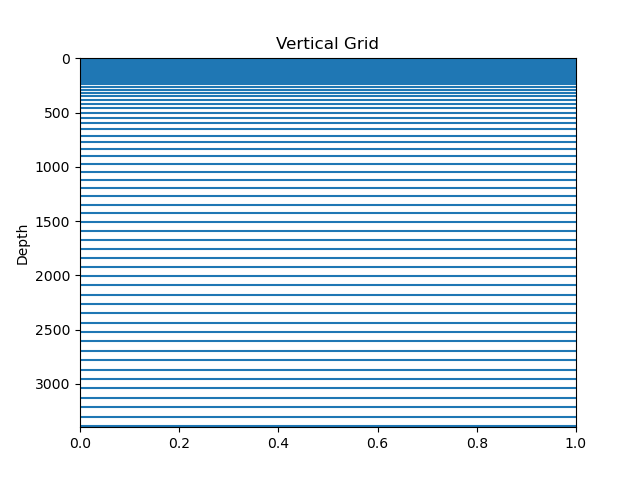

In [7]:
import matplotlib.pyplot as plt
plt.close()
# Create the plot
for depth in vgrid.z:
    plt.axhline(y=depth, linestyle='-')  # Horizontal lines

plt.ylim(max(vgrid.z) + 10, min(vgrid.z) - 10)  # Invert y-axis so deeper values go down
plt.ylabel("Depth")
plt.title("Vertical Grid")
plt.show()

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.
 - Compset: The set of models to be used in the Case. Standalone Ocean, Ocean-BGC, Ocean-Seaice, Ocean-Runoff, etc...

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. Below is an example setup:

In [8]:
from pathlib import Path

In [9]:
# CESM case (experiment) name
casename = "pan.bgc.1"

# CESM source root (Update this path accordingly!!!)
cesmroot ="/glade/work/mlevy/codes/CESM/cesm3_0_alpha07c_CROCO/"

# Place where all your input files go 
inputdir = Path.home()/"scratch" / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.


This is where we can change the model setup to what we want:
 - Interested in BGC? Check out [the demo for how to modify this notebook for BGC.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_bgc.html)
 - Interested in CICE? Check out [the demo for how to modify this notebook for CICE.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_cice.html)
 - Interested in Data Runoff from GLOFAS (or JRA)? Check out [the demo for how to modify this notebook for Data Runoff.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_rof.html)

In [10]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'ncgd0011',
    override = True,
    machine = "derecho",
    compset = "1850_DATM%JRA_SLND_SICE_MOM6%MARBL-BIO_SROF_SGLC_SWAV" # Change this as necessary to include whatever models you want. BGC? change MOM6 to MOM6%MARBL-BIO, CICE? Change SICE to CICE, GLOFAS Runoff? Change SROF to DROF%GLOFAS
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "pan.bgc.1" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "panama1".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "panama1" with the following properties:
 nx: 60, ny: 60. ocean mesh: /glade/u/home/manishrv/scratch/croc_input/pan.bgc.1/ocnice/ESMF_mesh_panama1_d63846.nc.

Running the create_newcase tool with the following command:

/glade/work/mlevy/codes/CESM/cesm3_0_alpha07c_CROCO/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6%MARBL-BIO_SROF_SGLC_SWAV --res pan.bgc.1 --case /glade/u/home/manishrv/croc_cases/pan.bgc.1 --machine derecho --run-unsupported --project ncgd0011 --non-local 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/u/home/manishrv/croc_cases/pan.bgc.1

Apply NTASK grid xml changes:

./xmlchange NTASKS_OCN=62 --no

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/manishrv/croc_cases/pan.bgc.1.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.

./xmlchange MOM6_MEMORY_MODE=dynamic_symmetric --non-local

./xmlchange ROOTPE_OCN=128 --non-local



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset.

## Step 3.1 Configure Initial Conditions and Forcings

 - Interested in adding tides? Check out [the demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_tides.html)
 - Interested in adding chlorophyll? Check out [the demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_chl.html)
 - Is the GLORYS data access function not working? Check out alternative options in [this demo.](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_data_products.html)

Configure Forcings MUST be modified if BGC or Data Runoff are part of the compset (and will throw an error). Check out the demos to see the changes required: [BGC Demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_bgc.html), [DROF Demo](https://crocodile-cesm.github.io/CrocoGallery/notebooks/features/add_rof.html).


In [11]:
case.configure_forcings(
    date_range = ["2000-01-01 00:00:00", "2000-02-01 00:00:00"],
        data_input_path = "/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/month_1",
        product_name = "CESM_OUTPUT",
        marbl_ic_filepath = "/glade/campaign/collections/gdex/data/d651077/cesmdata/inputdata/ocn/mom/tx0.66v1/ecosys_jan_IC_omip_latlon_1x1_180W_c231221.nc",
)

Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  VELOCITY_CONFIG = file
  TEMP_Z_INIT_FILE = TEMP_IC.nc
  SALT_Z_INIT_FILE = SALT_IC.nc
  Z_INIT_FILE_PTEMP_VAR = TEMP
  Z_INIT_FILE_SALT_VAR = SALT
  SURFACE_HEIGHT_IC_FILE = SSH_IC.nc
  SURFACE_HEIGHT_IC_VAR = SSH
  VELOCITY_FILE = VEL_IC.nc
  U_IC_VAR = UVEL
  V_IC_VAR = VVEL

  ! BGC Params
  MAX_FIELDS = 200
  MARBL_FESEDFLUX_FILE = /glade/u/home/manishrv/scratch/croc_input/pan.bgc.1/ocnice/fesedflux_total_reduce_oxic_panama1_d63846.nc
  MARBL_FEVENTFLUX_FILE = /glade/u/home/manishrv/scratch/croc_input/pan.bgc.1/ocnice/feventflux_5gmol_panama1_d63846.nc
  MARBL_TRACERS_IC_FILE = ecosys_jan_IC_omip_latlon_1x1_180W_c231221.nc
  READ_RIV_FLUXES = False

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COM

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [12]:
case.process_forcings() # You can turn off specific processing if it's already been processed previously with process_*name* = False. Ex. case.process_forcings(process_chl = False)

Parsing dataset...
1 file(s) found for variable 'UVEL'
1 file(s) found for variable 'VVEL'
1 file(s) found for variable 'SSH'
1 file(s) found for variable 'TEMP'
1 file(s) found for variable 'SALT'
1 file(s) found for variable 'PO4'
1 file(s) found for variable 'NO3'
1 file(s) found for variable 'SiO3'
1 file(s) found for variable 'NH4'
1 file(s) found for variable 'Fe'
1 file(s) found for variable 'Lig'
1 file(s) found for variable 'O2'
1 file(s) found for variable 'DIC'
1 file(s) found for variable 'DIC_ALT_CO2'
1 file(s) found for variable 'ALK'
1 file(s) found for variable 'ALK_ALT_CO2'
1 file(s) found for variable 'DOC'
1 file(s) found for variable 'DON'
1 file(s) found for variable 'DOP'
1 file(s) found for variable 'DOPr'
1 file(s) found for variable 'DONr'
1 file(s) found for variable 'DOCr'
1 file(s) found for variable 'microzooC'
1 file(s) found for variable 'mesozooC'
1 file(s) found for variable 'spChl'
1 file(s) found for variable 'spC'
1 file(s) found for variable 'spP'
1

INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Getting v points..
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Creating Regridder


Subsetted dataset for variable 'coccoCaCO3' saved to /glade/u/home/manishrv/scratch/croc_input/pan.bgc.1/cesm_output/cesm_output_extract_obc_workflow/subsetted_data/coccoCaCO3_subset.nc


INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Creating regridder for IC
Creating regridder for west


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Creating regridder for south
Creating regridder for north
Creating regridder for east
Regridding UVEL IC
UVEL IC regridded
Regridding VVEL IC
VVEL IC regridded
Regridding SSH IC
SSH IC regridded
Regridding TEMP IC
TEMP IC regridded
Regridding SALT IC
SALT IC regridded
Regridding UVEL west
UVEL west regridded
Regridding VVEL west
VVEL west regridded
Regridding SSH west
SSH west regridded
Regridding TEMP west
TEMP west regridded
Regridding SALT west
SALT west regridded
Regridding PO4 west
PO4 west regridded
Regridding NO3 west
NO3 west regridded
Regridding SiO3 west
SiO3 west regridded
Regridding NH4 west
NH4 west regridded
Regridding Fe west
Fe west regridded
Regridding Lig west
Lig west regridded
Regridding O2 west
O2 west regridded
Regridding DIC west
DIC west regridded
Regridding DIC_ALT_CO2 west
DIC_ALT_CO2 west regridded
Regridding ALK west
ALK west regridded
Regridding ALK_ALT_CO2 west
ALK_ALT_CO2 west regridded
Regridding DOC west
DOC west regridded
Regridding DON west
DON west r

INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..
INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically


Converting the UVEL variable because it is distance based with factor 0.01


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in UVEL_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to UVEL_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in UVEL_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished UVEL IC processing!
Converting the UVEL variable because it is distance based with factor 0.01
....Finished UVEL west processing!
Converting the UVEL variable because it is distance based with factor 0.01
....Finished UVEL south processing!
Converting the UVEL variable because it is distance based with factor 0.01
....Finished UVEL north processing!
Converting the UVEL variable because it is distance based with factor 0.01
....Finished UVEL east processing!
Converting the VVEL variable because it is distance based with factor 0.01


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in VVEL_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to VVEL_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in VVEL_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished VVEL IC processing!
Converting the VVEL variable because it is distance based with factor 0.01
....Finished VVEL west processing!
Converting the VVEL variable because it is distance based with factor 0.01
....Finished VVEL south processing!
Converting the VVEL variable because it is distance based with factor 0.01
....Finished VVEL north processing!
Converting the VVEL variable because it is distance based with factor 0.01
....Finished VVEL east processing!


INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..
INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding perpendicular dimension to SSH_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary


Did not find any of the provided z_dims in the dataset for SSH IC, assuming surface variable
Converting the SSH variable because it is distance based with factor 0.01
....Finished SSH IC processing!
Did not find any of the provided z_dims in the dataset for SSH west, assuming surface variable
Converting the SSH variable because it is distance based with factor 0.01
This variable is only a surface variable, skipping z_dim_act conversion.


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding perpendicular dimension to SSH_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding perpendicular dimension to SSH_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data ho

....Finished SSH west processing!
Did not find any of the provided z_dims in the dataset for SSH south, assuming surface variable
Converting the SSH variable because it is distance based with factor 0.01
This variable is only a surface variable, skipping z_dim_act conversion.
....Finished SSH south processing!
Did not find any of the provided z_dims in the dataset for SSH north, assuming surface variable
Converting the SSH variable because it is distance based with factor 0.01
This variable is only a surface variable, skipping z_dim_act conversion.
....Finished SSH north processing!
Did not find any of the provided z_dims in the dataset for SSH east, assuming surface variable
Converting the SSH variable because it is distance based with factor 0.01
This variable is only a surface variable, skipping z_dim_act conversion.
....Finished SSH east processing!
....Finished TEMP IC processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in TEMP_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to TEMP_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in TEMP_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished TEMP west processing!
....Finished TEMP south processing!
....Finished TEMP north processing!
....Finished TEMP east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in SALT_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to SALT_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in SALT_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished SALT IC processing!
....Finished SALT west processing!
....Finished SALT south processing!
....Finished SALT north processing!
....Finished SALT east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in PO4_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to PO4_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in PO4_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular d

....Finished PO4 west processing!
....Finished PO4 south processing!
....Finished PO4 north processing!
....Finished PO4 east processing!
....Finished NO3 west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in NO3_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to NO3_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in NO3_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular d

....Finished NO3 south processing!
....Finished NO3 north processing!
....Finished NO3 east processing!
....Finished SiO3 west processing!
....Finished SiO3 south processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in SiO3_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to SiO3_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in NH4_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incrementa

....Finished SiO3 north processing!
....Finished SiO3 east processing!
....Finished NH4 west processing!
....Finished NH4 south processing!
....Finished NH4 north processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in Fe_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to Fe_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in Fe_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dime

....Finished NH4 east processing!
....Finished Fe west processing!
....Finished Fe south processing!
....Finished Fe north processing!
....Finished Fe east processing!


INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in Lig_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to Lig_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in Lig_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to Lig_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regi

....Finished Lig west processing!
....Finished Lig south processing!
....Finished Lig north processing!
....Finished Lig east processing!
....Finished O2 west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in O2_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to O2_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in O2_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dime

....Finished O2 south processing!
....Finished O2 north processing!
....Finished O2 east processing!
....Finished DIC west processing!
....Finished DIC south processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DIC_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DIC_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DIC_ALT_CO2_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incr

....Finished DIC north processing!
....Finished DIC east processing!
....Finished DIC_ALT_CO2 west processing!
....Finished DIC_ALT_CO2 south processing!
....Finished DIC_ALT_CO2 north processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in ALK_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to ALK_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in ALK_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular d

....Finished DIC_ALT_CO2 east processing!
....Finished ALK west processing!
....Finished ALK south processing!
....Finished ALK north processing!
....Finished ALK east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in ALK_ALT_CO2_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to ALK_ALT_CO2_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in ALK_ALT_CO2_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regriddin

....Finished ALK_ALT_CO2 west processing!
....Finished ALK_ALT_CO2 south processing!
....Finished ALK_ALT_CO2 north processing!
....Finished ALK_ALT_CO2 east processing!
....Finished DOC west processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOC_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DOC_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOC_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental 

....Finished DOC south processing!
....Finished DOC north processing!
....Finished DOC east processing!
....Finished DON west processing!
....Finished DON south processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DON_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DON_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOP_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental 

....Finished DON north processing!
....Finished DON east processing!
....Finished DOP west processing!
....Finished DOP south processing!
....Finished DOP north processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOPr_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DOPr_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOPr_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with increment

....Finished DOP east processing!
....Finished DOPr west processing!
....Finished DOPr south processing!
....Finished DOPr north processing!
....Finished DOPr east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DONr_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DONr_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DONr_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished DONr west processing!
....Finished DONr south processing!
....Finished DONr north processing!
....Finished DONr east processing!
....Finished DOCr west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOCr_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to DOCr_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in DOCr_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicula

....Finished DOCr south processing!
....Finished DOCr north processing!
....Finished DOCr east processing!
....Finished microzooC west processing!
....Finished microzooC south processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in microzooC_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to microzooC_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in mesozooC_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Addin

....Finished microzooC north processing!
....Finished microzooC east processing!
....Finished mesozooC west processing!
....Finished mesozooC south processing!
....Finished mesozooC north processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spChl_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to spChl_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spChl_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendic

....Finished mesozooC east processing!
....Finished spChl west processing!
....Finished spChl south processing!
....Finished spChl north processing!
....Finished spChl east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spC_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to spC_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spC_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular d

....Finished spC west processing!
....Finished spC south processing!
....Finished spC north processing!
....Finished spC east processing!
....Finished spP west processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spP_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to spP_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spP_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental 

....Finished spP south processing!
....Finished spP north processing!
....Finished spP east processing!
....Finished spFe west processing!
....Finished spFe south processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in spFe_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to spFe_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatChl_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendic

....Finished spFe north processing!
....Finished spFe east processing!
....Finished diatChl west processing!
....Finished diatChl south processing!
....Finished diatChl north processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatC_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diatC_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatC_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendic

....Finished diatChl east processing!
....Finished diatC west processing!
....Finished diatC south processing!
....Finished diatC north processing!
....Finished diatC east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatP_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diatP_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatP_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendic

....Finished diatP west processing!
....Finished diatP south processing!
....Finished diatP north processing!
....Finished diatP east processing!
....Finished diatFe west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatFe_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diatFe_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatFe_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpen

....Finished diatFe south processing!
....Finished diatFe north processing!
....Finished diatFe east processing!
....Finished diatSi west processing!
....Finished diatSi south processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diatSi_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diatSi_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazChl_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpe

....Finished diatSi north processing!
....Finished diatSi east processing!
....Finished diazChl west processing!
....Finished diazChl south processing!
....Finished diazChl north processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazC_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diazC_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazC_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with increm

....Finished diazChl east processing!
....Finished diazC west processing!
....Finished diazC south processing!
....Finished diazC north processing!
....Finished diazC east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazP_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diazP_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazP_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendic

....Finished diazP west processing!
....Finished diazP south processing!
....Finished diazP north processing!
....Finished diazP east processing!
....Finished diazFe west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazFe_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to diazFe_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in diazFe_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpen

....Finished diazFe south processing!
....Finished diazFe north processing!
....Finished diazFe east processing!
....Finished coccoChl west processing!
....Finished coccoChl south processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoChl_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to coccoChl_segment_004
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoC_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with

....Finished coccoChl north processing!
....Finished coccoChl east processing!
....Finished coccoC west processing!
....Finished coccoC south processing!
....Finished coccoC north processing!


INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoP_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to coccoP_segment_003
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoP_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with inc

....Finished coccoC east processing!
....Finished coccoP west processing!
....Finished coccoP south processing!
....Finished coccoP north processing!
....Finished coccoP east processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoFe_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to coccoFe_segment_001
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoFe_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding per

....Finished coccoFe west processing!
....Finished coccoFe south processing!
....Finished coccoFe north processing!
....Finished coccoFe east processing!
....Finished coccoCaCO3 west processing!


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoCaCO3_segment_002
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to coccoCaCO3_segment_002
INFO:regional_mom6.regridding:Masking to bathymetry. If you don't want this, set bathymetry_path to None in the segment class.
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in coccoCaCO3_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:A

....Finished coccoCaCO3 south processing!
....Finished coccoCaCO3 north processing!
....Finished coccoCaCO3 east processing!
Merging U & V velocity files
Case is ready to be built: /glade/u/home/manishrv/croc_cases/pan.bgc.1


# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
qcmd -- ./case.build
./case.submit
```